In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/Shareddrives/682_Drive'
notebook_folder = drive_folder + '/696DS'
input_stories_dir = notebook_folder + '/input_stories'
gold_endings_dir = notebook_folder + '/gold_endings'
log_file_path = notebook_folder + '/output_new.txt'
#output_stories_dir = notebook_folder + '/output_stories/gpt_4o'
#output_stories_dir = notebook_folder + '/output_stories/Claude_3.5'
#output_stories_dir = notebook_folder + '/output_stories/Gemini_2.5_Pro'
%cd {notebook_folder}

import os

Mounted at /content/drive
/content/drive/Shareddrives/682_Drive/696DS


In [2]:
!pip install spacy_syllables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.2 MB/s eta 0:00:00


In [3]:
!pip install benepar

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00
  Created wheel for benepar: filename=benepar-0.2.0-py3-none-any.whl size=37625 sha256=e8f101bfb7f281dc8e08d1fe374fec21609bf594b0b7708579e16a4569a58f41
  Stored i

In [4]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=e8e6d07db00b492e9a4fa6b465abe1e35133362360aaeb71c9b9831f146f216e
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [5]:
import spacy
from collections import Counter
from statistics import mean
import re

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim, dot_score, euclidean_sim, manhattan_sim
from sklearn.cluster import AgglomerativeClustering
from spacy_syllables import SpacySyllables
#import benepar
from tqdm import tqdm

#from utils import cache

In [6]:
class SimpleLogger:
    def __init__(self, file_path="output.log"):
        self.file_path = file_path

    def log(self, message: str):
        with open(self.file_path, "a") as f:
            f.write(message + "\n")

In [9]:
Logger = SimpleLogger(log_file_path)

In [7]:
DEF_EMB_MODEL = "thenlper/gte-large"
DEF_EMB_TYPE = "sentence_embedding"
DEF_DIST_FN = "cosine"
DEF_SPACY_LANG = "en_core_web_sm"
DEF_PREPROCESSING_ARGS = {
    "lower": True,
    "remove_punct": True,
    "remove_stopwords": True,
    "lemmatize": True,
    "dominant_k": None,
    "unique": True
}

SPACY_ENGINE_CACHE = {}
EMB_MODEL_CACHE = {}
EMBEDDING_CACHE = {}
SPACY_CACHE = {}


In [8]:
def load_spacy_engine(language=DEF_SPACY_LANG, include_syllables=False, include_constituency=False):
    #print(f"Loading spacy engine: {language}")
    engine = spacy.load(language)
    if include_syllables:
        engine.add_pipe("syllables", after="tagger")
    if include_constituency:
        engine.add_pipe('benepar', config={'model': 'benepar_en3'})
    return engine

In [9]:
def get_spacy_doc(text, include_syllables=False, include_constituency=False):
    spacy_engine = load_spacy_engine(include_syllables=include_syllables, include_constituency=include_constituency)
    return spacy_engine(text)

In [10]:
def load_emb_model(model=DEF_EMB_MODEL):
    print(f"Loading embedding model: {model}")
    return SentenceTransformer(model)

In [11]:
def get_embedding(text, model=DEF_EMB_MODEL, emb_type=DEF_EMB_TYPE, emb_model=None):


    output_value = "sentence_embedding"

    if "token" in emb_type:
        output_value = "token_embeddings"

    # Uncomment below line if want to use "thenlper-gte-large" model for embedding
    # embeddings = emb_model.encode(text, output_value=output_value)
    embeddings = model.encode(text, task="text-matching")

    if embeddings.ndim == 2:
        embeddings = embeddings.mean(axis=0)

    return embeddings

In [12]:
def compute_text_embedding(text, emb_model=DEF_EMB_MODEL, emb_type=DEF_EMB_TYPE, emb_strategy="direct", emb_model_pass=None,
                            preprocessing_args=DEF_PREPROCESSING_ARGS):
    if emb_strategy == "direct":
        return get_embedding(text, emb_model, emb_type, emb_model_pass)
    elif emb_strategy == "by_word":
        words = get_words(text, **preprocessing_args)
        return get_embedding(words, emb_model, emb_type, emb_model_pass)
    elif emb_strategy == "by_sentence":
        sentences = get_sentences(text)
        return get_embedding(sentences, emb_model, emb_type, emb_model_pass)
    else:
        raise ValueError(f"Invalid embedding strategy: {emb_strategy}")

In [13]:
def get_sentences(text):
    doc = get_spacy_doc(text)
    return [sent.text for sent in doc.sents]

In [14]:
def get_words(text, lower=True, remove_punct=True, remove_stopwords=True, lemmatize=True, unique=True, dominant_k=None):
    doc = get_spacy_doc(text)
    tokens = [token for token in doc]

    if remove_punct:
        tokens = [token for token in tokens if not token.is_punct]

    if remove_stopwords:
        tokens = [token for token in tokens if not token.is_stop]

    words = [token.text for token in tokens]

    if lemmatize:
        words = [token.lemma_ for token in tokens]

    if lower:
        words = [word.lower() for word in words]

    if dominant_k is None or dominant_k == 0 or dominant_k >= len(words):
        if unique:
            print("Selecting unique words")
            return list(set(words))
        return words

    word_freq = Counter(words)

    return [w[0] for w in word_freq.most_common(dominant_k)]


In [15]:
def compute_sem_dis(emb1, emb2, distance_fn=DEF_DIST_FN):
    if distance_fn == "cosine":
        return (1 - cos_sim(emb1, emb2)).item()
    elif distance_fn == "dot":
        return (1 - dot_score(emb1, emb2)).item()
    elif distance_fn == "euclidean":
        return (-euclidean_sim(emb1, emb2)).item()
    elif distance_fn == "manhattan":
        return (-manhattan_sim(emb1, emb2)).item()
    else:
        raise ValueError(f"Invalid distance function: {distance_fn}")


In [16]:
def compute_avg_pairwise_distances(embeddings, distance_fn=DEF_DIST_FN):
    if len(embeddings) <= 1:
        return [0]

    avg_pairwise_distances = []
    for i in range(len(embeddings)):
        pairwise_distances = []
        for j in range(len(embeddings)):
            if i != j:
                distance = compute_sem_dis(embeddings[i], embeddings[j], distance_fn)
                pairwise_distances.append(distance)
        avg_pairwise_distances.append(mean(pairwise_distances))
    return avg_pairwise_distances

In [17]:
def compute_avg_sem_dis(text, emb_model=DEF_EMB_MODEL, emb_type=DEF_EMB_TYPE, distance_fn=DEF_DIST_FN, emb_model_pass=None, preprocessing_args=DEF_PREPROCESSING_ARGS):
    words = get_words(text, **preprocessing_args)
    print(f"Number of words: {len(words)}")
    print(words)
    embeddings = [get_embedding(word, emb_model, emb_type, emb_model_pass) for word in words]
    print(f"Embedding length of sample first word - {words[0]} is this - {len(embeddings[0])}")
    return mean(compute_avg_pairwise_distances(embeddings, distance_fn))

In [18]:
def compute_novelty(story_versions, emb_model=DEF_EMB_MODEL, emb_type=DEF_EMB_TYPE,
                    distance_fn=DEF_DIST_FN, preprocessing_args=DEF_PREPROCESSING_ARGS):

    # story_versions = List of endings
    emb_model_pass = load_emb_model(emb_model)

    corpus = "".join(story_versions)

    corpus_avg_sem_dis = compute_avg_sem_dis(corpus, emb_model, emb_type, distance_fn, emb_model_pass, preprocessing_args)
    print(f"This is corpus avg sem dis: {corpus_avg_sem_dis}")

    novelty_scores = []
    for text in tqdm(story_versions,desc="Computing novelty score for each story ending"):
      text_avg_sem_dis = compute_avg_sem_dis(text, emb_model, emb_type, distance_fn, emb_model_pass, preprocessing_args)
      print(f"Text avg sem dis: {text_avg_sem_dis}")

      novelty_scores.append(2 * abs(text_avg_sem_dis - corpus_avg_sem_dis))


    return novelty_scores


In [19]:
def compute_surprise(text, emb_model=DEF_EMB_MODEL, emb_type=DEF_EMB_TYPE, distance_fn=DEF_DIST_FN, preprocessing_args=DEF_PREPROCESSING_ARGS):
    sentences = get_sentences(text)
    emb_model_pass = load_emb_model(emb_model)

    if len(sentences) <= 1:
        return 0, []

    sentence_avg_sem_distances = [compute_avg_sem_dis(sentence, emb_model, emb_type, distance_fn, emb_model_pass,preprocessing_args) for sentence in sentences]
    raw_surprises = [abs(sentence_avg_sem_distances[i] - sentence_avg_sem_distances[i - 1]) for i in range(1, len(sentence_avg_sem_distances))]

    return (2 / len(raw_surprises)) * sum(raw_surprises), raw_surprises

In [23]:
def compute_n_gram_diversity(text, max_n_gram=5, remove_punct=True):
    words = get_words(text, lower=True, remove_punct=remove_punct, remove_stopwords=False, lemmatize=False, unique=False)

    all_n_grams = []

    for n in range(1, max_n_gram + 1):
        all_n_grams.append([tuple(words[i:i + n]) for i in range(len(words) - n + 1)])

    all_n_gram_freqs = [Counter(n_grams) for n_grams in all_n_grams]
    n_gram_diversity = [len(n_gram_freqs) / len(n_grams) for n_grams, n_gram_freqs in zip(all_n_grams, all_n_gram_freqs)]

    return n_gram_diversity, all_n_gram_freqs

In [20]:
def compute_inverse_homogenization(texts, emb_model=DEF_EMB_MODEL, emb_type=DEF_EMB_TYPE, emb_strategy="direct",
                                   distance_fn=DEF_DIST_FN, preprocessing_args=DEF_PREPROCESSING_ARGS):
    #Uncomment below line if want to use "thenlper-gte-large" model for embedding
    #emb_model_pass = load_emb_model(emb_model)
    emb_model_pass = None
    text_embeddings = [compute_text_embedding(text, emb_model, emb_type, emb_strategy, emb_model_pass, preprocessing_args) for text in texts]
    return compute_avg_pairwise_distances(text_embeddings, distance_fn)

In [21]:

#from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Function to read text from a Word file
def read_story_from_txt(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()  # Read full text


In [22]:
def get_endings_in_list(story_text):
    pattern = r"(Ending \d+:)"  # Pattern to identify versions
    matches = re.split(pattern, story_text)  # Split text
    #print(len(matches))
    # Process the matches into a list
    ending_versions = {}
    for i in range(1, len(matches), 2):  # Skip every alternate element (even indices are separators)
        version_title = matches[i].strip()  # Get "Ending n:"
        version_text = matches[i + 1].strip() if i + 1 < len(matches) else ""  # Get the corresponding text
        ending_versions[version_title] = version_text  # Store in dictionary

    story_list = list(ending_versions.values())
    return story_list

In [23]:
# For GPT-4o and Gemini story extraction
def gpt_gemini_story_extraction(output_stories_dir):
  output_stories_list = os.listdir(output_stories_dir)
  story_endings = {}
  for idx, story_out_file in enumerate(output_stories_list):
    #print(idx, story_out_file)
    story_id = os.path.splitext(story_out_file)[0].replace("_out", "")
    story_out_path = os.path.join(output_stories_dir, story_out_file)
    story_text = read_story_from_txt(story_out_path)
    endings = get_endings_in_list(story_text)
    #print(len(endings))
    story_endings[story_id] = endings
  return story_endings




In [24]:
pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 12.8 MB/s eta 0:00:00


In [25]:
from docx import Document

def read_docx(file_path):
    doc = Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)


In [26]:
# For Claude story extraction
def doc_story_extraction(output_stories_dir):
  output_stories_list = os.listdir(output_stories_dir)
  story_endings = {}
  for idx, story_out_file in enumerate(output_stories_list):
    #print(idx, story_out_file)
    story_id = story_id = os.path.splitext(story_out_file)[0]
    #print(story_id)
    story_out_path = os.path.join(output_stories_dir, story_out_file)
    story_text = read_docx(story_out_path)
    #print(story_text)
    endings = get_endings_in_list(story_text)
    #print(len(endings))
    story_endings[story_id] = endings
  return story_endings


In [27]:
!pip install nltk

In [28]:
def preprocess(text, lower=True, remove_punct=True, remove_stopwords=True, lemmatize=True):
    doc = get_spacy_doc(text)
    tokens = [token for token in doc]

    if remove_punct:
        tokens = [token for token in tokens if not token.is_punct]

    if remove_stopwords:
        tokens = [token for token in tokens if not token.is_stop]

    words = [token.text for token in tokens]

    if lemmatize:
        words = [token.lemma_ for token in tokens]

    if lower:
        words = [word.lower() for word in words]

    return set(words)

In [29]:
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets of words."""
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0


In [30]:
from itertools import combinations
def lexical_diversity(endings):
    if len(endings) < 2:
        return 0.0

    processed_endings = [preprocess(end) for end in endings]
    similarities = [
        jaccard_similarity(e1, e2)
        for e1, e2 in combinations(processed_endings, 2)
    ]

    avg_similarity = sum(similarities) / len(similarities)
    return 1 - avg_similarity


####Loading embedding Model-

In [31]:
embedding_model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/734k [00:00<?, ?B/s]

custom_st.py:   0%|          | 0.00/8.78k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- mha.py
- mlp.py
- xlm_padding.py
- embedding.py
- block.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was down

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

# GPT- 4o Endings -

In [32]:
output_stories_dir = notebook_folder + '/output_stories/gpt_4o/batch_2'
story_endings = gpt_gemini_story_extraction(output_stories_dir)
print(len(story_endings))

10


###Semantic Diversity

In [34]:
Logger.log(f"\n Semantic Diversity scores for GPT-4o: \n")
semantic_div_scores_list = []
creativity_results_gpt = {}
for story_id, endings_list in tqdm(story_endings.items(), desc="Computing Semantic Diversity scores for all story endings: "):
  print(f"\n StoryId {story_id}\n: ")
  creativity_results_gpt[story_id] = {}

  inv_homo_scores = compute_inverse_homogenization(endings_list, embedding_model)
  avg_semantic_div_score = mean(inv_homo_scores)
  creativity_results_gpt[story_id]["semantic_div_score"] = avg_semantic_div_score
  semantic_div_scores_list.append(avg_semantic_div_score)
  print(f"\n Scores for all individual endings: {inv_homo_scores}")
  print(f"\n Average semantic diversity score: {avg_semantic_div_score}")
  Logger.log(f"\n StoryId {story_id}\n: ")
  Logger.log(f"\n Scores for all individual endings: {inv_homo_scores}")
  Logger.log(f"\n Average semantic diversity score: {avg_semantic_div_score}")

Logger.log(f"\n Scores for stories in a list: {semantic_div_scores_list}")
print(creativity_results_gpt)
print(f"\n Average Semantic Diversity Score for all story endings generated using GPT-4o: \n {mean(semantic_div_scores_list)}")
Logger.log(f"\n Average Semantic Diversity Score for all story endings generated using GPT-4o: \n {mean(semantic_div_scores_list)}")


Computing Semantic Diversity scores for all story endings:   0%|          | 0/10 [00:00<?, ?it/s]


 StoryId 1253
: 


Computing Semantic Diversity scores for all story endings:  10%|█         | 1/10 [02:05<18:53, 125.91s/it]


 Scores for all individual endings: [0.10975401103496552, 0.10519672930240631, 0.12042662501335144, 0.13792484998703003, 0.11724472045898438]

 Average semantic diversity score: 0.11810938715934753

 StoryId 21279
: 


Computing Semantic Diversity scores for all story endings:  20%|██        | 2/10 [04:21<17:30, 131.31s/it]


 Scores for all individual endings: [0.11504282057285309, 0.11529114842414856, 0.11877284944057465, 0.09523431956768036, 0.13065631687641144]

 Average semantic diversity score: 0.11499949097633362

 StoryId 22589
: 


Computing Semantic Diversity scores for all story endings:  30%|███       | 3/10 [06:46<16:05, 137.98s/it]


 Scores for all individual endings: [0.08007495105266571, 0.1095658391714096, 0.09253241121768951, 0.10981407761573792, 0.08935581147670746]

 Average semantic diversity score: 0.09626861810684204

 StoryId 22890
: 


Computing Semantic Diversity scores for all story endings:  40%|████      | 4/10 [08:52<13:18, 133.07s/it]


 Scores for all individual endings: [0.15746693313121796, 0.1845395565032959, 0.14562228322029114, 0.15591290593147278, 0.18543694913387299]

 Average semantic diversity score: 0.16579572558403016

 StoryId 23535
: 


Computing Semantic Diversity scores for all story endings:  50%|█████     | 5/10 [11:26<11:42, 140.55s/it]


 Scores for all individual endings: [0.07432588934898376, 0.07310286164283752, 0.07003520429134369, 0.07306356728076935, 0.059771955013275146]

 Average semantic diversity score: 0.0700598955154419

 StoryId 23006
: 


Computing Semantic Diversity scores for all story endings:  60%|██████    | 6/10 [13:38<09:11, 137.78s/it]


 Scores for all individual endings: [0.1374945491552353, 0.15393707156181335, 0.1106836199760437, 0.12800954282283783, 0.10987839102745056]

 Average semantic diversity score: 0.12800063490867614

 StoryId 29317
: 


Computing Semantic Diversity scores for all story endings:  70%|███████   | 7/10 [15:49<06:46, 135.62s/it]


 Scores for all individual endings: [0.10670299828052521, 0.11320900917053223, 0.11352194845676422, 0.13917554914951324, 0.1318962126970291]

 Average semantic diversity score: 0.12090114355087281

 StoryId 51414
: 


Computing Semantic Diversity scores for all story endings:  80%|████████  | 8/10 [18:16<04:38, 139.07s/it]


 Scores for all individual endings: [0.1416662186384201, 0.12126632034778595, 0.14157316088676453, 0.11657105386257172, 0.13745923340320587]

 Average semantic diversity score: 0.13170719742774964

 StoryId 32665
: 


Computing Semantic Diversity scores for all story endings:  90%|█████████ | 9/10 [20:32<02:18, 138.09s/it]


 Scores for all individual endings: [0.12719978392124176, 0.08760292828083038, 0.10843019187450409, 0.09899899363517761, 0.11895452439785004]

 Average semantic diversity score: 0.10823728442192078

 StoryId 51351
: 


Computing Semantic Diversity scores for all story endings: 100%|██████████| 10/10 [23:01<00:00, 138.17s/it]


 Scores for all individual endings: [0.09808875620365143, 0.10935348272323608, 0.11375990509986877, 0.10569135844707489, 0.10777509212493896]

 Average semantic diversity score: 0.10693371891975403
{'1253': {'semantic_div_score': 0.11810938715934753}, '21279': {'semantic_div_score': 0.11499949097633362}, '22589': {'semantic_div_score': 0.09626861810684204}, '22890': {'semantic_div_score': 0.16579572558403016}, '23535': {'semantic_div_score': 0.0700598955154419}, '23006': {'semantic_div_score': 0.12800063490867614}, '29317': {'semantic_div_score': 0.12090114355087281}, '51414': {'semantic_div_score': 0.13170719742774964}, '32665': {'semantic_div_score': 0.10823728442192078}, '51351': {'semantic_div_score': 0.10693371891975403}}

 Average Semantic Diversity Score for all story endings generated using GPT-4o: 
 0.11610130965709686


###Lexical Diversity

In [42]:
log_file_path = notebook_folder + "/LEX_DIV-gpt-gen.txt"
Logger = SimpleLogger(log_file_path)


In [43]:
Logger.log(f"\n Lexical Diversity scores for GPT-4o: \n")
lexical_div_scores_list = []
creativity_results_gpt = {}
for story_id, endings_list in tqdm(story_endings.items(), desc="Computing Lexical Diversity scores for all story endings: "):
  print(f"\n StoryId {story_id}\n: ")
  creativity_results_gpt[story_id] = {}
  lexical_div_score = lexical_diversity(endings_list)
  creativity_results_gpt[story_id]["lexical_div_score"] = lexical_div_score
  lexical_div_scores_list.append(lexical_div_score)
  print(f"\n Lexical Diversity score: {lexical_div_score}")
  Logger.log(f"\n StoryId {story_id}\n: ")
  Logger.log(f"\n Lexical Diversity score: {lexical_div_score}")

Logger.log(f"\n Scores for stories in a list: {lexical_div_scores_list}")
print(creativity_results_gpt)
print(f"\n Average Lexical Diversity Score for all story endings generated using GPT-4o: \n {mean(lexical_div_scores_list)}")
Logger.log(f"\n Average Lexical Diversity Score for all story endings generated using GPT-4o: \n {mean(lexical_div_scores_list)}")


Computing Lexical Diversity scores for all story endings:   0%|          | 0/10 [00:00<?, ?it/s]


 StoryId 1253
: 


Computing Lexical Diversity scores for all story endings:  10%|█         | 1/10 [00:04<00:37,  4.18s/it]


 Lexical Diversity score: 0.7944972360170277

 StoryId 21279
: 


Computing Lexical Diversity scores for all story endings:  20%|██        | 2/10 [00:09<00:40,  5.06s/it]


 Lexical Diversity score: 0.8472548996405505

 StoryId 22589
: 


Computing Lexical Diversity scores for all story endings:  30%|███       | 3/10 [00:14<00:34,  4.97s/it]


 Lexical Diversity score: 0.8388786142376007

 StoryId 22890
: 


Computing Lexical Diversity scores for all story endings:  40%|████      | 4/10 [00:18<00:28,  4.69s/it]


 Lexical Diversity score: 0.8565603811671982

 StoryId 23535
: 


Computing Lexical Diversity scores for all story endings:  50%|█████     | 5/10 [00:25<00:25,  5.18s/it]


 Lexical Diversity score: 0.8176019786732373

 StoryId 23006
: 


Computing Lexical Diversity scores for all story endings:  60%|██████    | 6/10 [00:29<00:19,  4.81s/it]


 Lexical Diversity score: 0.8223719974351875

 StoryId 29317
: 


Computing Lexical Diversity scores for all story endings:  70%|███████   | 7/10 [00:36<00:16,  5.49s/it]


 Lexical Diversity score: 0.8311262433419472

 StoryId 51414
: 


Computing Lexical Diversity scores for all story endings:  80%|████████  | 8/10 [00:41<00:10,  5.34s/it]


 Lexical Diversity score: 0.8414905873283551

 StoryId 32665
: 


Computing Lexical Diversity scores for all story endings:  90%|█████████ | 9/10 [00:46<00:05,  5.27s/it]


 Lexical Diversity score: 0.8455934265756515

 StoryId 51351
: 


Computing Lexical Diversity scores for all story endings: 100%|██████████| 10/10 [00:52<00:00,  5.30s/it]


 Lexical Diversity score: 0.8567895109746313
{'1253': {'lexical_div_score': 0.7944972360170277}, '21279': {'lexical_div_score': 0.8472548996405505}, '22589': {'lexical_div_score': 0.8388786142376007}, '22890': {'lexical_div_score': 0.8565603811671982}, '23535': {'lexical_div_score': 0.8176019786732373}, '23006': {'lexical_div_score': 0.8223719974351875}, '29317': {'lexical_div_score': 0.8311262433419472}, '51414': {'lexical_div_score': 0.8414905873283551}, '32665': {'lexical_div_score': 0.8455934265756515}, '51351': {'lexical_div_score': 0.8567895109746313}}

 Average Lexical Diversity Score for all story endings generated using GPT-4o: 
 0.8352164875391387


# Gemini-2.5-Pro Endings Surprise Scores-

In [32]:
output_stories_dir = notebook_folder + '/output_stories/Gemini_2.5_Pro/batch_2'
story_endings = doc_story_extraction(output_stories_dir)
print((story_endings))

10


In [33]:
print(story_endings)

{'22890': ['The Weight of "If"\n\nI thanked Van Manderpootz, the professor’s cheerful demeanor a stark contrast to the icy grip of terror still squeezing my chest. "Horrible!" I\'d murmured, the word feeling inadequate to describe the chaos, the screams, the green surge of water engulfing the observation room. He’d chuckled at my use of "we", not knowing – or perhaps knowing all too well, in his academic way – about Joanna. I didn\'t enlighten him. I simply bade him good-night and went home, the image of her pale face, her closed silver eyes, burned into my mind. \xa0 \n\nThe city outside was the same, vibrant and indifferent. People hurried to their destinations, blissfully unaware of the countless alternate realities flickering around them, each a testament to a different choice, a missed connection, a moment of tardiness or punctuality. My father\'s voice echoed in my head, sharp and critical. "Dixon," he\'d said, "you have no conception whatever of time. None whatever". How wrong h

In [34]:
log_file_path = notebook_folder + "/LEX_DIV-gemini-gen.txt"
Logger = SimpleLogger(log_file_path)

###Semantic Diversity

In [35]:
Logger.log(f"\n Semantic Diversity scores for Gemini-2.5-Pro: \n")
semantic_div_scores_list = []
creativity_results_gemini = {}
for story_id, endings_list in tqdm(story_endings.items(), desc="Computing Semantic Diversity scores for all story endings: "):
  print(f"\n StoryId {story_id}\n: ")
  creativity_results_gemini[story_id] = {}

  inv_homo_scores = compute_inverse_homogenization(endings_list, embedding_model)
  avg_semantic_div_score = mean(inv_homo_scores)
  creativity_results_gemini[story_id]["semantic_div_score"] = avg_semantic_div_score
  semantic_div_scores_list.append(avg_semantic_div_score)
  print(f"\n Scores for all individual endings: {inv_homo_scores}")
  print(f"\n Average semantic diversity score: {avg_semantic_div_score}")
  Logger.log(f"\n StoryId {story_id}\n: ")
  Logger.log(f"\n Scores for all individual endings: {inv_homo_scores}")
  Logger.log(f"\n Average semantic diversity score: {avg_semantic_div_score}")

Logger.log(f"\n Scores for stories in a list: {semantic_div_scores_list}")
print(creativity_results_gemini)
print(f"\n Average Semantic Diversity Score for all story endings generated using Gemini-2.5-Pro: \n {mean(semantic_div_scores_list)}")
Logger.log(f"\n Average Semantic Diversity Score for all story endings generated using Gemini-2.5-Pro: \n {mean(semantic_div_scores_list)}")


Computing Semantic Diversity scores for all story endings:   0%|          | 0/10 [00:00<?, ?it/s]


 StoryId 22890
: 


Computing Semantic Diversity scores for all story endings:  10%|█         | 1/10 [02:06<19:01, 126.85s/it]


 Scores for all individual endings: [0.33442896604537964, 0.3232468217611313, 0.3491012156009674, 0.30950939655303955, 0.2852800339460373]

 Average semantic diversity score: 0.32031328678131105

 StoryId 1253
: 


Computing Semantic Diversity scores for all story endings:  20%|██        | 2/10 [03:46<14:47, 110.89s/it]


 Scores for all individual endings: [0.31223879754543304, 0.26726095378398895, 0.2352365255355835, 0.32360193133354187, 0.27243950963020325]

 Average semantic diversity score: 0.2821555435657501

 StoryId 23535
: 


Computing Semantic Diversity scores for all story endings:  30%|███       | 3/10 [06:24<15:26, 132.29s/it]


 Scores for all individual endings: [0.25024908781051636, 0.25894099473953247, 0.221326744556427, 0.2661664128303528, 0.20535788536071778, 0.2647822380065918]

 Average semantic diversity score: 0.2444705605506897

 StoryId 23006
: 


Computing Semantic Diversity scores for all story endings:  40%|████      | 4/10 [08:02<11:52, 118.75s/it]


 Scores for all individual endings: [0.2816399782896042, 0.27985166013240814, 0.2600255310535431, 0.29092369973659515, 0.2892134338617325]

 Average semantic diversity score: 0.28033086061477663

 StoryId 22589
: 


Computing Semantic Diversity scores for all story endings:  50%|█████     | 5/10 [09:50<09:34, 114.83s/it]


 Scores for all individual endings: [0.24617204070091248, 0.2079247236251831, 0.26596856117248535, 0.31938043236732483, 0.25820696353912354]

 Average semantic diversity score: 0.25953054428100586

 StoryId 32665
: 


Computing Semantic Diversity scores for all story endings:  60%|██████    | 6/10 [12:13<08:17, 124.47s/it]


 Scores for all individual endings: [0.22411169111728668, 0.24496404826641083, 0.21659718453884125, 0.22669629752635956, 0.2348046898841858]

 Average semantic diversity score: 0.22943478226661682

 StoryId 21279
: 


Computing Semantic Diversity scores for all story endings:  70%|███████   | 7/10 [13:38<05:34, 111.60s/it]


 Scores for all individual endings: [0.32563547790050507, 0.28758783638477325, 0.31110629439353943, 0.3182366192340851, 0.38701894879341125]

 Average semantic diversity score: 0.3259170353412628

 StoryId 29317
: 


Computing Semantic Diversity scores for all story endings:  80%|████████  | 8/10 [15:47<03:54, 117.12s/it]


 Scores for all individual endings: [0.2675993889570236, 0.2218862771987915, 0.2446790635585785, 0.22913512587547302, 0.2207237333059311]

 Average semantic diversity score: 0.23680471777915954

 StoryId 51351
: 


Computing Semantic Diversity scores for all story endings:  90%|█████████ | 9/10 [17:40<01:55, 115.74s/it]


 Scores for all individual endings: [0.2686223089694977, 0.2738884389400482, 0.3099706470966339, 0.3348645865917206, 0.3239887058734894]

 Average semantic diversity score: 0.30226693749427797

 StoryId 51414
: 


Computing Semantic Diversity scores for all story endings: 100%|██████████| 10/10 [19:07<00:00, 114.79s/it]


 Scores for all individual endings: [0.30350691080093384, 0.31736262142658234, 0.32234521210193634, 0.32993726432323456, 0.35351382195949554]

 Average semantic diversity score: 0.3253331661224365
{'22890': {'semantic_div_score': 0.32031328678131105}, '1253': {'semantic_div_score': 0.2821555435657501}, '23535': {'semantic_div_score': 0.2444705605506897}, '23006': {'semantic_div_score': 0.28033086061477663}, '22589': {'semantic_div_score': 0.25953054428100586}, '32665': {'semantic_div_score': 0.22943478226661682}, '21279': {'semantic_div_score': 0.3259170353412628}, '29317': {'semantic_div_score': 0.23680471777915954}, '51351': {'semantic_div_score': 0.30226693749427797}, '51414': {'semantic_div_score': 0.3253331661224365}}

 Average Semantic Diversity Score for all story endings generated using Gemini-2.5-Pro: 
 0.2806557434797287


###Lexical Diversity

In [36]:
Logger.log(f"\n Lexical Diversity scores for Gemini-2.5-Pro: \n")
lexical_div_scores_list = []
creativity_results_gemini = {}
for story_id, endings_list in tqdm(story_endings.items(), desc="Computing Lexical Diversity scores for all story endings: "):
  print(f"\n StoryId {story_id}\n: ")
  creativity_results_gemini[story_id] = {}
  lexical_div_score = lexical_diversity(endings_list)
  creativity_results_gemini[story_id]["lexical_div_score"] = lexical_div_score
  lexical_div_scores_list.append(lexical_div_score)
  print(f"\n Lexical Diversity score: {lexical_div_score}")
  Logger.log(f"\n StoryId {story_id}\n: ")
  Logger.log(f"\n Lexical Diversity score: {lexical_div_score}")

Logger.log(f"\n Scores for stories in a list: {lexical_div_scores_list}")
print(creativity_results_gemini)
print(f"\n Average Lexical Diversity Score for all story endings generated using Gemini-2.5-Pro: \n {mean(lexical_div_scores_list)}")
Logger.log(f"\n Average Lexical Diversity Score for all story endings generated using Gemini-2.5-Pro: \n {mean(lexical_div_scores_list)}")


Computing Lexical Diversity scores for all story endings:   0%|          | 0/10 [00:00<?, ?it/s]


 StoryId 22890
: 


Computing Lexical Diversity scores for all story endings:  10%|█         | 1/10 [00:05<00:47,  5.27s/it]


 Lexical Diversity score: 0.8321902906157395

 StoryId 1253
: 


Computing Lexical Diversity scores for all story endings:  20%|██        | 2/10 [00:11<00:44,  5.57s/it]


 Lexical Diversity score: 0.8557249822499412

 StoryId 23535
: 


Computing Lexical Diversity scores for all story endings:  30%|███       | 3/10 [00:16<00:37,  5.42s/it]


 Lexical Diversity score: 0.8348099994415641

 StoryId 23006
: 


Computing Lexical Diversity scores for all story endings:  40%|████      | 4/10 [00:21<00:31,  5.27s/it]


 Lexical Diversity score: 0.8280848861218544

 StoryId 22589
: 


Computing Lexical Diversity scores for all story endings:  50%|█████     | 5/10 [00:27<00:27,  5.50s/it]


 Lexical Diversity score: 0.885289858103782

 StoryId 32665
: 


Computing Lexical Diversity scores for all story endings:  60%|██████    | 6/10 [00:31<00:20,  5.14s/it]


 Lexical Diversity score: 0.8455770267339509

 StoryId 21279
: 


Computing Lexical Diversity scores for all story endings:  70%|███████   | 7/10 [00:37<00:15,  5.31s/it]


 Lexical Diversity score: 0.8645097982759801

 StoryId 29317
: 


Computing Lexical Diversity scores for all story endings:  80%|████████  | 8/10 [00:41<00:10,  5.03s/it]


 Lexical Diversity score: 0.8499969688905664

 StoryId 51351
: 


Computing Lexical Diversity scores for all story endings:  90%|█████████ | 9/10 [00:46<00:05,  5.03s/it]


 Lexical Diversity score: 0.8644296698391845

 StoryId 51414
: 


Computing Lexical Diversity scores for all story endings: 100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


 Lexical Diversity score: 0.8673728401160102
{'22890': {'lexical_div_score': 0.8321902906157395}, '1253': {'lexical_div_score': 0.8557249822499412}, '23535': {'lexical_div_score': 0.8348099994415641}, '23006': {'lexical_div_score': 0.8280848861218544}, '22589': {'lexical_div_score': 0.885289858103782}, '32665': {'lexical_div_score': 0.8455770267339509}, '21279': {'lexical_div_score': 0.8645097982759801}, '29317': {'lexical_div_score': 0.8499969688905664}, '51351': {'lexical_div_score': 0.8644296698391845}, '51414': {'lexical_div_score': 0.8673728401160102}}

 Average Lexical Diversity Score for all story endings generated using Gemini-2.5-Pro: 
 0.8527986320388573


#Visualisations - Batch 2

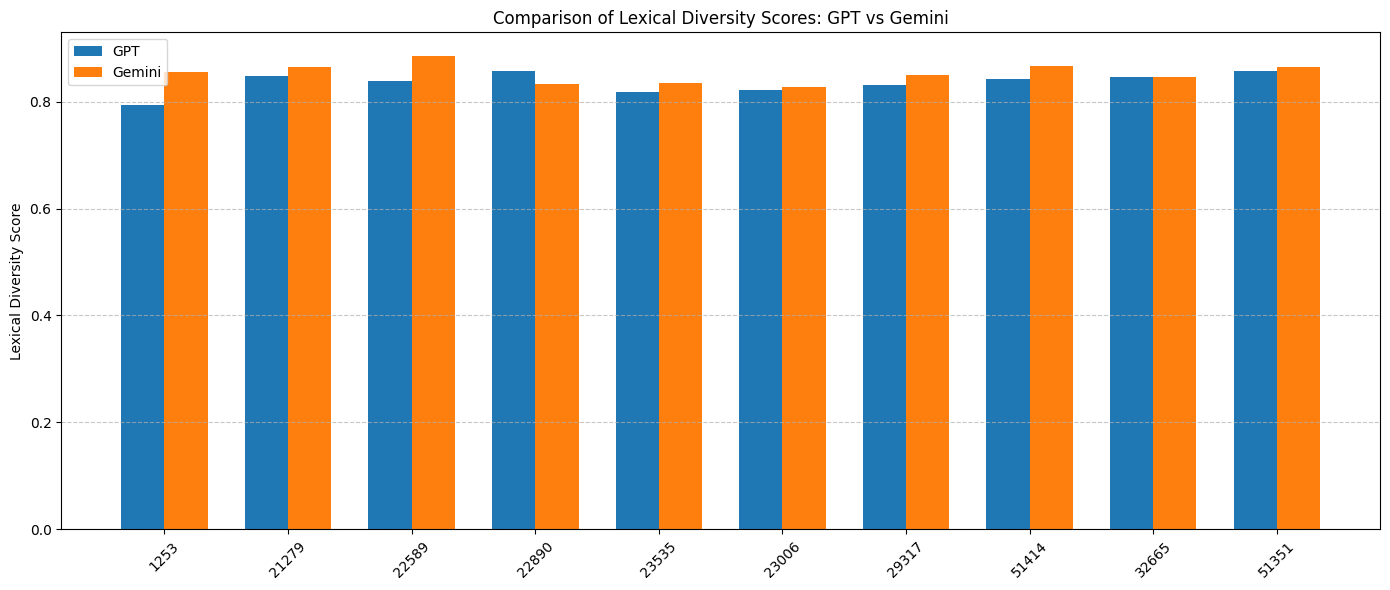

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data
gpt_scores = {
    '1253': 0.7944972360170277, '21279': 0.8472548996405505, '22589': 0.8388786142376007,
    '22890': 0.8565603811671982, '23535': 0.8176019786732373, '23006': 0.8223719974351875,
    '29317': 0.8311262433419472, '51414': 0.8414905873283551, '32665': 0.8455934265756515,
    '51351': 0.8567895109746313
}

gemini_scores = {
    '22890': 0.8321902906157395, '1253': 0.8557249822499412, '23535': 0.8348099994415641,
    '23006': 0.8280848861218544, '22589': 0.885289858103782, '32665': 0.8455770267339509,
    '21279': 0.8645097982759801, '29317': 0.8499969688905664, '51351': 0.8644296698391845,
    '51414': 0.8673728401160102
}

story_ids = list(gpt_scores.keys())
x = np.arange(len(story_ids))  # the label locations
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, [gpt_scores[sid] for sid in story_ids], width, label='GPT')
bars2 = ax.bar(x + width/2, [gemini_scores[sid] for sid in story_ids], width, label='Gemini')

# Labels, title, legend, and grid
ax.set_ylabel('Lexical Diversity Score')
ax.set_title('Comparison of Lexical Diversity Scores: GPT vs Gemini')
ax.set_xticks(x)
ax.set_xticklabels(story_ids, rotation=45)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


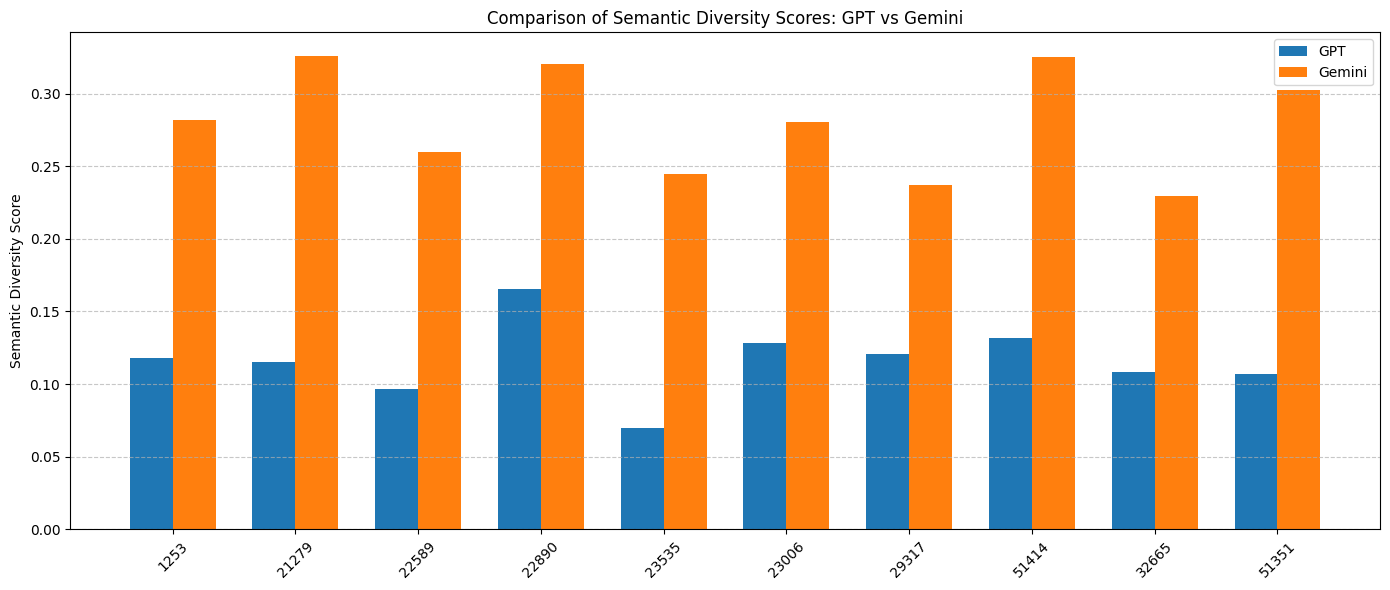

In [38]:
# Semantic diversity scores for GPT and Gemini
gpt_semantic_scores = {
    '1253': 0.11810938715934753, '21279': 0.11499949097633362, '22589': 0.09626861810684204,
    '22890': 0.16579572558403016, '23535': 0.0700598955154419, '23006': 0.12800063490867614,
    '29317': 0.12090114355087281, '51414': 0.13170719742774964, '32665': 0.10823728442192078,
    '51351': 0.10693371891975403
}

gemini_semantic_scores = {
    '22890': 0.32031328678131105, '1253': 0.2821555435657501, '23535': 0.2444705605506897,
    '23006': 0.28033086061477663, '22589': 0.25953054428100586, '32665': 0.22943478226661682,
    '21279': 0.3259170353412628, '29317': 0.23680471777915954, '51351': 0.30226693749427797,
    '51414': 0.3253331661224365
}

story_ids = list(gpt_semantic_scores.keys())
x = np.arange(len(story_ids))  # the label locations
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, [gpt_semantic_scores[sid] for sid in story_ids], width, label='GPT')
bars2 = ax.bar(x + width/2, [gemini_semantic_scores[sid] for sid in story_ids], width, label='Gemini')

# Labels, title, legend, and grid
ax.set_ylabel('Semantic Diversity Score')
ax.set_title('Comparison of Semantic Diversity Scores: GPT vs Gemini')
ax.set_xticks(x)
ax.set_xticklabels(story_ids, rotation=45)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Visualisations - Batch 1

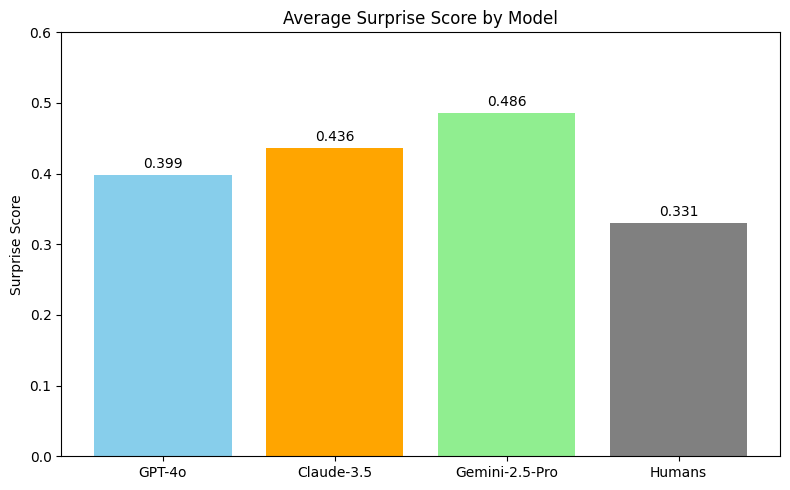

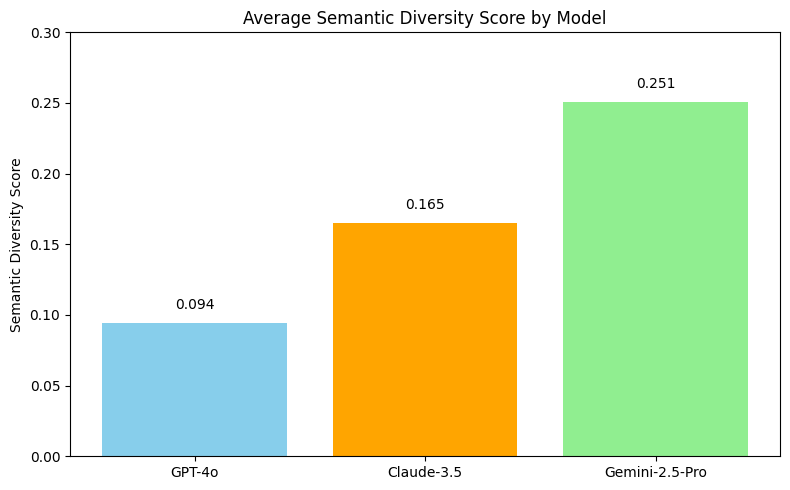

In [ ]:
import matplotlib.pyplot as plt

# Models and Human
models = ['GPT-4o', 'Claude-3.5', 'Gemini-2.5-Pro', 'Humans']

# Surprise scores
surprise_scores = [0.3987, 0.4365, 0.4857, 0.3306]

# Semantic diversity scores (Note: No human value provided)
sem_diversity_scores = [0.0940, 0.1650, 0.2505]

# Colors for consistent visualization
colors = ['skyblue', 'orange', 'lightgreen', 'gray']

# Plot Average Surprise Score
plt.figure(figsize=(8, 5))
plt.bar(models, surprise_scores, color=colors)
plt.title('Average Surprise Score by Model')
plt.ylabel('Surprise Score')
plt.ylim(0, 0.6)
for i, v in enumerate(surprise_scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Plot Average Semantic Diversity Score
plt.figure(figsize=(8, 5))
plt.bar(models[:-1], sem_diversity_scores, color=colors[:-1])  # No Human value here
plt.title('Average Semantic Diversity Score by Model')
plt.ylabel('Semantic Diversity Score')
plt.ylim(0, 0.3)
for i, v in enumerate(sem_diversity_scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()



# lexical_scores = [0.7789209868201038, 0.7416479251206134, 0.8501243778254858]
# plt.figure(figsize=(8, 5))
# plt.bar(models[:-1], lexical_scores, color=colors[:-1])  # No Human value here
# plt.title('Average Lexical Diversity Score by Model')
# plt.ylabel('Lexical Diversity Score')
# plt.ylim(0, 0.3)
# for i, v in enumerate(lexical_scores):
#     plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
# plt.tight_layout()


# # Display the plot
# plt.show()



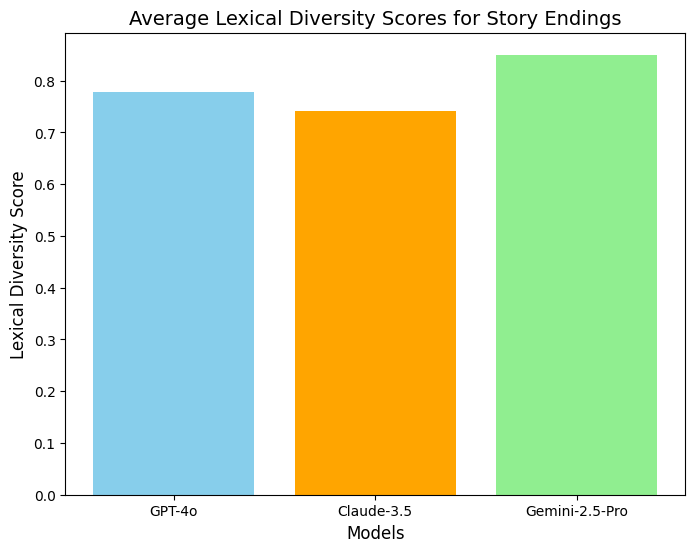

In [ ]:
import matplotlib.pyplot as plt

# Lexical Diversity Scores
models = ['GPT-4o', 'Claude-3.5', 'Gemini-2.5-Pro']
scores = [0.7789209868201038, 0.7416479251206134, 0.8501243778254858]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, scores, color=['skyblue', 'orange', 'lightgreen'])

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Lexical Diversity Score', fontsize=12)
plt.title('Average Lexical Diversity Scores for Story Endings', fontsize=14)

# Display the plot
plt.show()
